In [1]:
!pip install -e ../.

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///Users/mayanknautiyal/Desktop/Codes/CVAEI
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cvaei


In [2]:
import sys
sys.path.insert(0, '../')  # Adjust the path as necessary


In [3]:
import cvaei
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torch import nn, optim
from cvaei.models.cvae_inference import CVAE
from cvaei.examples.gk_dist import GKDistribution

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print(torch.cuda.is_available())
print(torch.version.cuda)



Using device: cpu
False
None


In [4]:
gk_dist = GKDistribution()
train_theta_norm, train_data_norm, theta_normalizer, data_normalizer, val_theta_norm, val_data_norm = gk_dist.prepare_data(10000)
observed_data = gk_dist.observed_data()
gk_dist.check_normalizer()

Training Theta Shape: torch.Size([10000, 4])
Training Data Shape: torch.Size([10000, 1000])
Validation Theta Shape: torch.Size([10000, 4])
Validation Data Shape: torch.Size([10000, 1000])
Normalization and denormalization process is consistent for both parameters and observed data.


In [5]:
gk_dist.get_info()

true_params is on device: cpu
theta_normalizer uses device: cpu
data_normalizer uses device: cpu


In [6]:
train_theta_norm.shape, train_data_norm.shape

(torch.Size([10000, 4]), torch.Size([10000, 1000]))

# Initialise the Model

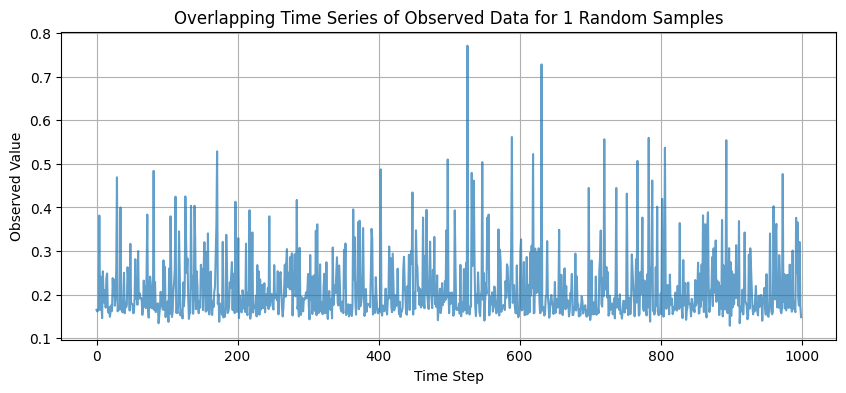

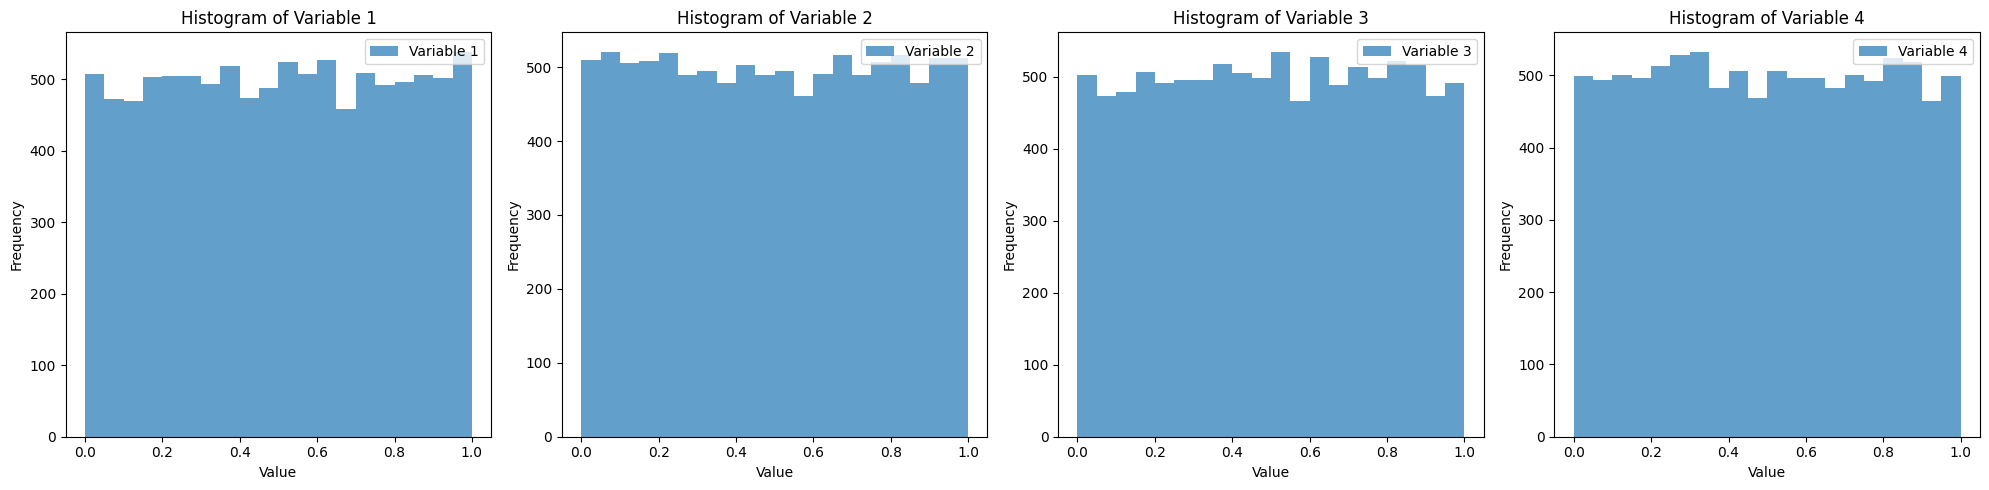

In [7]:
gk_dist.plot_observation(train_data_norm, num_samples =1)
gk_dist.plot_prior(train_theta_norm)

# Define the CVAE Network

In [8]:
input_dim = 4
latent_dim = 20
conditional_dim = 1000
encoder_hidden_dims = [100]
decoder_hidden_dims = [2048,2048]
activation_fn = nn.ELU()

network = CVAE(input_dim=input_dim, 
               latent_dim=latent_dim, 
               output_dim=input_dim,
                conditional_dim=conditional_dim,
                encoder_hidden_dims=encoder_hidden_dims,
                decoder_hidden_dims=decoder_hidden_dims,
                activation_fn = activation_fn,
                w_recon=1.0, 
                w_misfit=0.1,
)

optimizer = optim.AdamW(network.parameters(), lr=1e-5)

train_dataset = TensorDataset(train_data_norm, train_theta_norm)
val_dataset = TensorDataset(val_data_norm, val_theta_norm)

train_loader = DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True)
validation_loader = DataLoader(dataset=val_dataset, batch_size=1024, shuffle=False)

network.tune_hyperparameters(train_loader = train_loader, 
                             validation_loader = validation_loader)

(raylet) Warning: The actor ImplicitFunc is very large (48 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


2024-02-19 14:29:05,931	ERROR tune_controller.py:1374 -- Trial task failed for trial train_with_config_d8c39_00005
Traceback (most recent call last):
  File "/Users/mayanknautiyal/Library/Python/3.9/lib/python/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/Users/mayanknautiyal/Library/Python/3.9/lib/python/site-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/Users/mayanknautiyal/Library/Python/3.9/lib/python/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/Users/mayanknautiyal/Library/Python/3.9/lib/python/site-packages/ray/_private/worker.py", line 2626, in get
    raise value
ray.exceptions.RayActorError: The actor died unexpectedly before finishing this task.
	class_name: ImplicitFunc
	actor_id: 7b34f6f9fc1ef3ecbf79d79a01000000
	pid: 69172
	namespace: ee300bff-6f80-47f7-b5cc-c72e

(raylet) Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1807, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1908, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1813, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1754, in ray._raylet.execute_task.function_executor
  File "/Users/mayanknautiyal/Library/Python/3.9/lib/python/site-packages/ray/_private/function_manager.py", line 726, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "/Users/mayanknautiyal/Library/Python/3.9/lib/python/site-packages/ray/_private/function_manager.py", line 638, in temporary_actor_method
    raise RuntimeError(
RuntimeError: The actor with name ImplicitFunc failed to import on the worker. This may be because needed library dependencies are not installed in the worker environment:

Traceback (most recent call last):
  File "/Users/mayanknautiyal/Library/Python/3.9/lib/python/site-packages/ray/_pr

2024-02-19 14:29:06,137	ERROR tune_controller.py:1374 -- Trial task failed for trial train_with_config_d8c39_00004
Traceback (most recent call last):
  File "/Users/mayanknautiyal/Library/Python/3.9/lib/python/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/Users/mayanknautiyal/Library/Python/3.9/lib/python/site-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/Users/mayanknautiyal/Library/Python/3.9/lib/python/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/Users/mayanknautiyal/Library/Python/3.9/lib/python/site-packages/ray/_private/worker.py", line 2626, in get
    raise value
ray.exceptions.RayActorError: The actor died unexpectedly before finishing this task.
	class_name: ImplicitFunc
	actor_id: dceb439a6945b351a945440e01000000
	pid: 69171
	namespace: ee300bff-6f80-47f7-b5cc-c72e

RuntimeError: No best trial found for the given metric: loss. This means that no trial has reported this metric, or all values reported for this metric are NaN. To not ignore NaN values, you can set the `filter_nan_and_inf` arg to False.

In [ ]:
print(network)

In [ ]:
network.train_model(train_loader=train_loader,
                    validation_loader= validation_loader,
                    optimizer=optimizer,
                    epochs=20, 
                    device=device,
                    theta_normalizer=theta_normalizer,
                    data_normalizer=data_normalizer,
                    forward_model= gk_dist.simulator)

In [ ]:
network.plot_loss()

# Inference

In [ ]:
post = network.get_posterior(observed_data= observed_data, num_samples=1000)
post = theta_normalizer.inverse_transform(post)


In [ ]:
gk_dist.plot_posterior(post)

In [ ]:
gk_dist.posterior_hist(post)